In [26]:
import pickle
import json

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from warnings import filterwarnings

filterwarnings('ignore')

In [7]:
from sklearn.linear_model import LogisticRegression
from util.data import load_hidden_data
from util.model import load_model, get_device_memory_report, clear_cuda_cache

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, r2_score

In [35]:
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
get_device_memory_report(device)

Device: cuda:7 [NVIDIA RTX 6000 Ada Generation]
Free Memory: 47.08/47.50 GB [99.11%]


In [48]:
model_name = 'Llama-3.1-8B-Instruct'
grammar_type = 'complex_NP_island'

hidden_states = load_hidden_data(model_name, grammar_type)

In [49]:
def get_layer_r2(layer_idx):

    good_hidden_states = np.array([ex['good_hidden_states'][layer_idx][-1] for ex in hidden_states])
    bad_hidden_states  = np.array([ex['bad_hidden_states'][layer_idx][-1] for ex in hidden_states])
    X = np.concatenate([good_hidden_states, bad_hidden_states], axis=0)
    y = np.concatenate([np.ones(len(good_hidden_states)), np.zeros(len(bad_hidden_states))], axis=0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    logistic_regression = LogisticRegression(penalty='l1', solver='liblinear')
    logistic_regression.fit(X_train, y_train)

    y_pred = logistic_regression.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    return r2

In [50]:
from tqdm import tqdm

n_layers = hidden_states[0]['good_hidden_states'].shape[0]

r2_scores = []
for layer_idx in tqdm(range(n_layers)):
    r2_scores.append(get_layer_r2(layer_idx))

r2_scores = np.array(r2_scores)

100%|██████████| 33/33 [00:19<00:00,  1.65it/s]


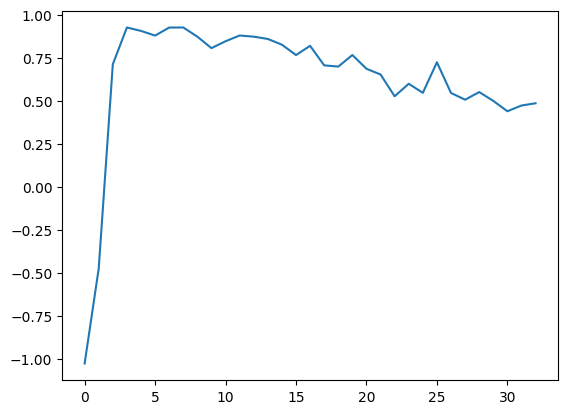

In [51]:
import matplotlib.pyplot as plt

plt.plot(r2_scores)
plt.show()